## Time Series Decomposition

**Data Source:** [Weather history download Basel](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604)

**date:** 2020-05-26

In the previous notebooks, we have looked into the basic visualization techniques and correlation analysis for time series data. After we have a peak into the data with such tools, if we are convinced that the data has a meaningful time-dependent structure, we now want to go deeper and decompose time series data into the different ingredients and understand what are the sources of variation we see in the data. In this notebook, we will review the basic terminologies and simple techniques for time series decomposition.

## Prepare Notebook

In [15]:
# Main data packages. 
import numpy as np
import pandas as pd
# Data Viz. 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data 

In [16]:
raw_df = pd.read_csv('../../../data/beer.csv')
raw_df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [17]:
raw_df.shape

(476, 2)

## Format Data 

We add some additional features. 

In [42]:
data_df = raw_df.copy()

data_df = data_df.rename(columns={
    'Monthly beer production': 'production'}
)

In [43]:
data_df['Month_index']=data_df['Month'].apply(lambda x: pd.Period(x, freq='M'))
data_df.reset_index(inplace=True)
data_df.head()

,index,Month,production,Month_index
0,0,1956-01,93.2,1956-01
1,1,1956-02,96.0,1956-02
2,2,1956-03,95.2,1956-03
3,3,1956-04,77.1,1956-04
4,4,1956-05,70.9,1956-05


/opt/conda/envs/btsa/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


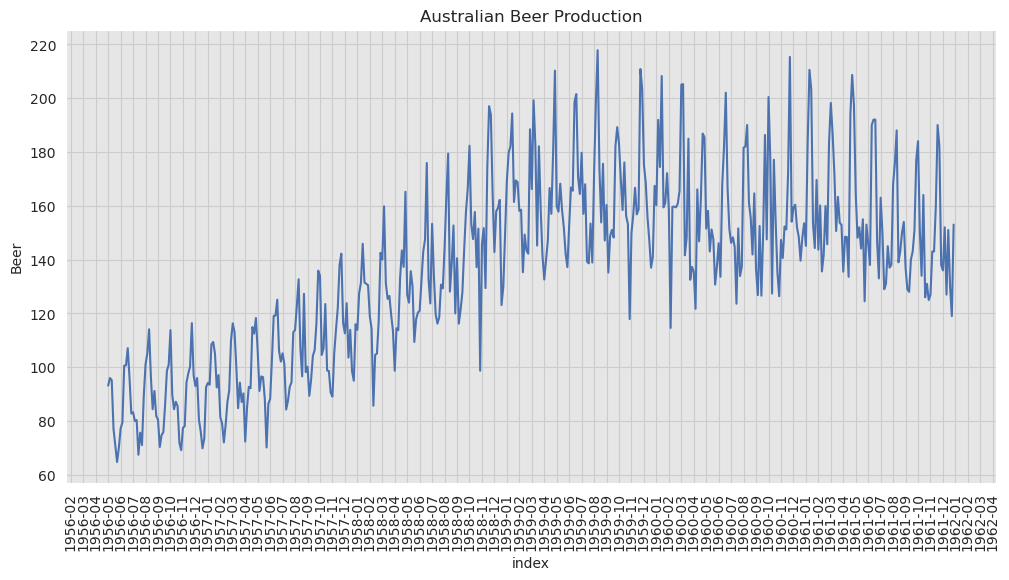

In [44]:
# Plot data. 
fig, ax = plt.subplots()
sns.lineplot(x='index', y='production', data=data_df, ax=ax)
ax.set(title='Australian Beer Production', ylabel='Beer')
ax.set_xticklabels(data_df['Month'].values.tolist())
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.xticks(rotation=90)
plt.savefig(f'../images/beer_production.png', dpi=200, bbox_inches='tight');

## Components in Beer data
* Let's repeat what we did for in the visualization EDA notebook
    * Do we see overarching, global **trend** in the data? - Yes, positive upward trend.
    * Do we see cyclic variation in the data that is repeated at a constant frequency? (a.k.a Seasonality) - Yes

## Finding a global trend - Smoothing

* Usuall the first question of data analysis is "Can we extract general, global pattern here?"
* In time series with cyclic seasonal variation, this means that we want to smooth out this seasonality and let the global trend manifest itself.
* Most classical, first go-to way for this smoothing is to use Moving Average.

- [Moving Average](https://en.wikipedia.org/wiki/Moving_average)

In [45]:
ma = 12

smooth_data_df = data_df \
    .reset_index() \
    .assign(date = lambda x: x['Month'].transform(pd.to_datetime))

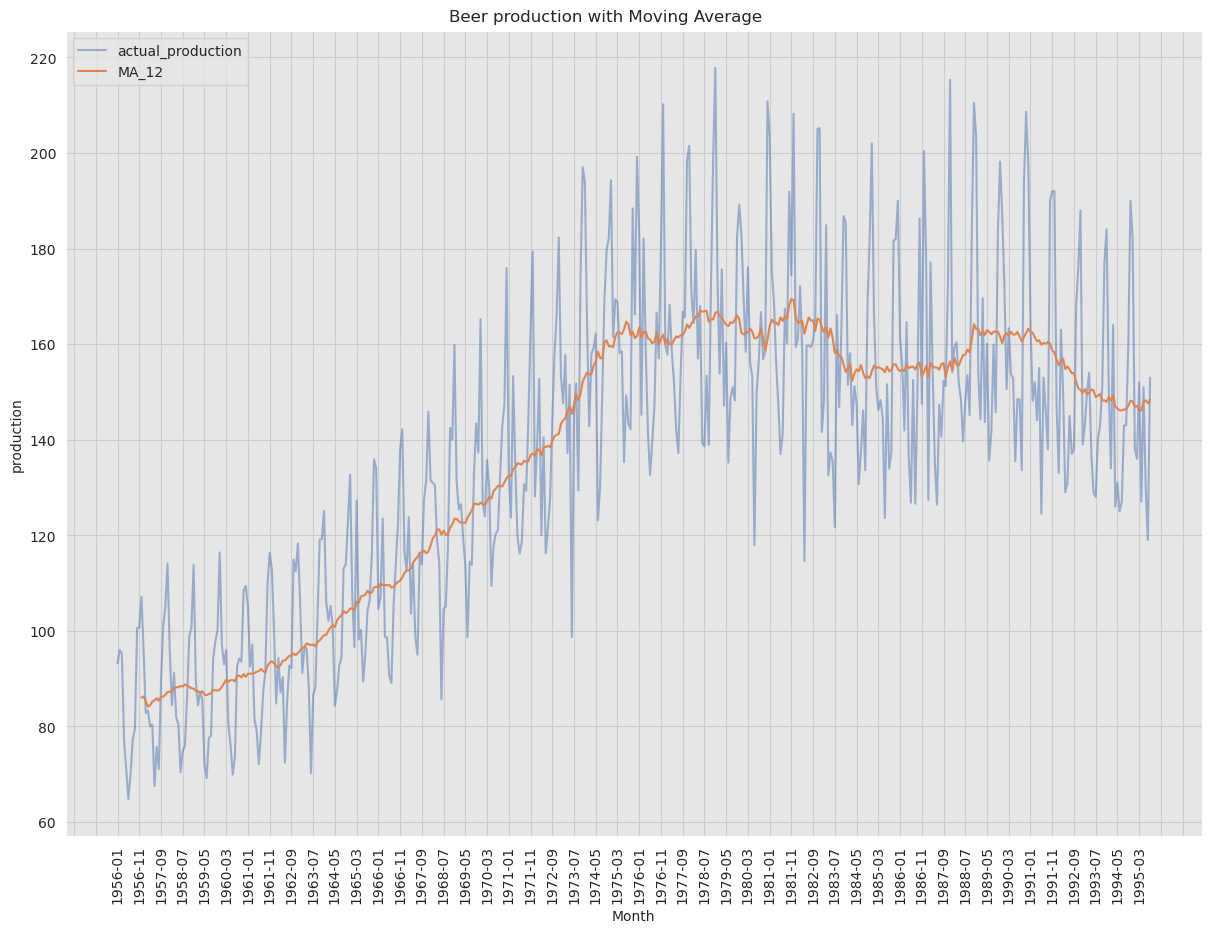

In [46]:
# Smooth and plot.
fig, ax = plt.subplots(1, 1, figsize=(12, 9), constrained_layout=True)
smooth_data_df[f'MA_{m}'] = smooth_data_df['production'].rolling(window=m).mean()
sns.lineplot(x='Month', y='production', label='actual_production', data=smooth_data_df, alpha=0.5, ax=ax)
sns.lineplot(x='Month', y=f'MA_{m}', label=f'MA_{m}', data=smooth_data_df, color=sns_c[i + 1], ax=ax)
ax.legend(loc='upper left')
#ax.set_xticklabels(data_df['Month'].values.tolist())
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=90)
plt.suptitle('Beer production with Moving Average', y=1.02)
plt.savefig(f'../images/beer_ma.png', dpi=200, bbox_inches='tight');

* We used moving average of 12 units to reflect the yearly structure of the data. 
* The orange line is capturing overarching trend of positive increase over time 
* Then the remaining question is, how much of those cyclic up & down movements in the data can be explained by the 12-month structure in the data? In other words, can we separate out the variation due to seasonality from this global trend?

## Time Series Decomposition using Moving average

* We can use the method `seasonal_decompose` from `statsmodels.tsa.seasonal` to decompose the daily data. This method is based on moving averages.  
* The stpes inside of this function is
    * we first undercover global trend using Moving average
    * we **de-trend** our data by substituding the trend values from the original data
    * then we estimate seasonal component by taking averages of each season's value - for example, the effect of January is the average of all de-trended January values in the data

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We use the parameter `period` = 365 to extract the yearly seasonality. 
seas_decomp = seasonal_decompose(
    x=data_df['production'], 
    model='additive', 
    period=12
)

/opt/conda/envs/btsa/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


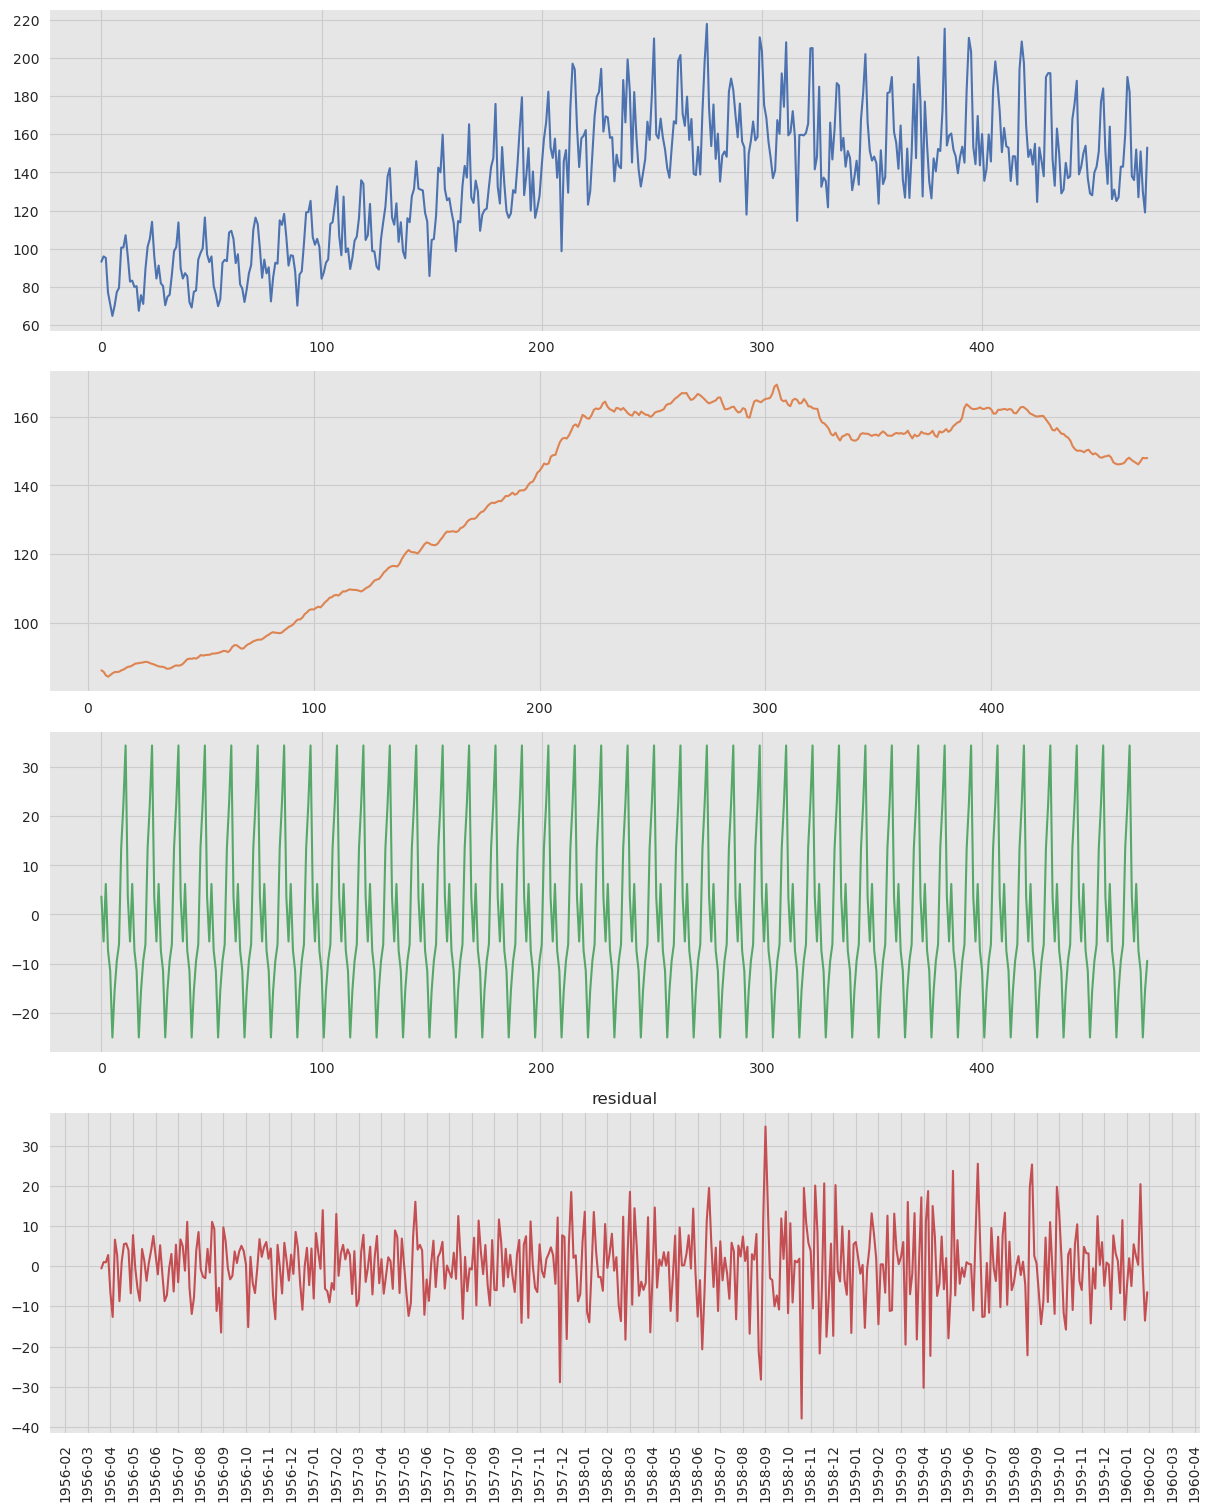

In [48]:
fig, ax = plt.subplots(4, 1, figsize=(12, 15), constrained_layout=True)

seas_decomp.observed.plot(c=sns_c[0], ax=ax[0])

seas_decomp.trend.plot(c=sns_c[1], ax=ax[1])

seas_decomp.seasonal.plot(c=sns_c[2], ax=ax[2])

seas_decomp.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
ax[3].set_xticklabels(data_df['Month'].values.tolist())
ax[3].xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=90)

plt.savefig(f'../images/beer_seasonal_decomposed.png', dpi=200, bbox_inches='tight');

* We observe that the residual in the later time points are bigger - this is probably becuase moving average over-smoothed the small, rapid rises and falls in the data since 1985 summer
* This is a known drawback of time series decomposition with moving average - a popular alternative method is STL. 

### Decomposition with STL

[statsmodel_STL](https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html)

* STL uses LOWESS technique instead of moving average for smoothing. 
* Therefore, STL has mush more flexibility with how to set up the seasonality parameter - this can be adjusted by playing wiht LOESS smoothing degree

In [49]:
from statsmodels.tsa.seasonal import STL

In [57]:
STL_beer = pd.Series(data_df['production'].values, index=pd.date_range('1-1-1956', periods=len(data_df['production']), freq='M'))

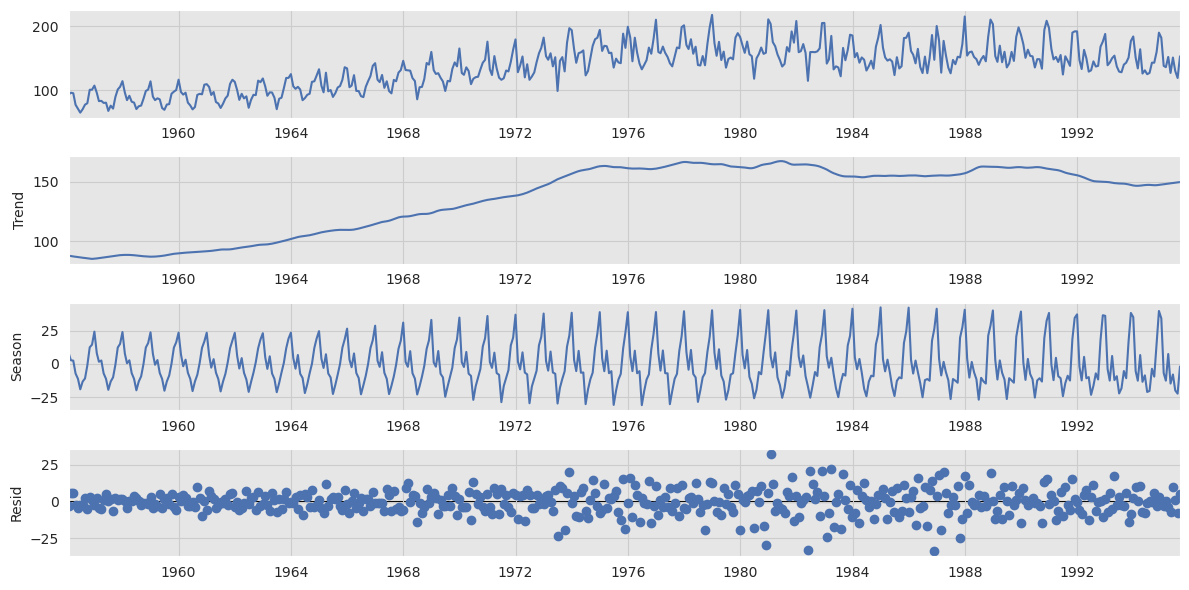

In [59]:
stl = STL(STL_beer, seasonal=13)
res = stl.fit()
fig = res.plot()